# Custom training: basics

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

tf.enable_eager_execution()

## Variables

Tensors are immutable stateless objects.<br>
A Variable is an object which stores a value and, when used in a TensorFlow computation, will implicitly read from this stored value.

In [2]:
# Using python state
x = tf.zeros([10, 10])
x += 2
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


In [3]:
v = tf.Variable(1.0)
assert v.numpy() == 1.0

# Re-assign the value
v.assign(3.0)
assert v.numpy() == 3.0

# Use `v` in a TensorFlow operation like tf.square() and reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0

Computations using Variables are automatically traced when computing gradients. For Variables representing embeddings TensorFlow will do sparse updates by default, which are more computation and memory efficient.

## Example: Fitting a linear model

Let's now put the few concepts we have so far ---`Tensor`, `GradientTape`, `Variable` --- to build and train a simple model. This typically involves a few steps:

1. Define the model.
2. Define a loss function.
3. Obtain training data.
4. Run through the training data and use an "optimizer" to adjust the variables to fit the data.

In this tutorial, we'll walk through a trivial example of a simple linear model: `f(x) = x * W + b`, which has two variables - `W` and `b`. Furthermore, we'll synthesize data such that a well trained model would have `W = 3.0` and `b = 2.0`.

### Define the model

Let's define a simple class to encapsulate the variables and the computation.

In [4]:
class Model(object):
    def __init__(self):
        # Initialize variable to (5.0, 0.0)
        # In practice, these should be initialized to random values.
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)

    def __call__(self, x):
        return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 15.0

### Define a loss function

A loss function measures how well the output of a model for a given input matches the desired output. Let's use the standard L2 loss.

In [5]:
def loss(predicted_y, desired_y):
    return tf.reduce_mean(tf.square(predicted_y - desired_y))

### Obtain training data

Let's synthesize the training data with some noise.

In [6]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random_normal(shape=[NUM_EXAMPLES])
noise   = tf.random_normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

Before we train the model let's visualize where the model stands right now. We'll plot the model's predictions in red and the training data in blue.

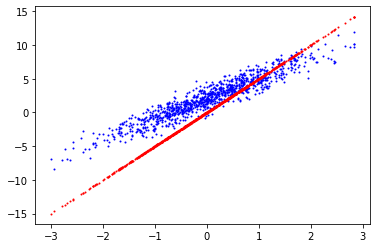

Current loss: 
8.930453


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b', s=1)
plt.scatter(inputs, model(inputs), c='r', s=1)
plt.show()

print('Current loss: '),
print(loss(model(inputs), outputs).numpy())

### Define a training loop

We now have our network and our training data. Let's train it, i.e., use the training data to update the model's variables (`W` and `b`) so that the loss goes down using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent). There are many variants of the gradient descent scheme that are captured in `tf.train.Optimizer` implementations. We'd highly recommend using those implementations, but in the spirit of building from first principles, in this particular example we will implement the basic math ourselves.

In [8]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
        
    dW, db = t.gradient(current_loss, [model.W, model.b])
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

Finally, let's repeatedly run through the training data and see how `W` and `b` evolve.

Epoch  0: W=5.00 b=0.00, loss=8.93045
Epoch  1: W=4.63 b=0.41, loss=6.20027
Epoch  2: W=4.33 b=0.73, loss=4.40699
Epoch  3: W=4.08 b=1.00, loss=3.22897
Epoch  4: W=3.88 b=1.21, loss=2.45503
Epoch  5: W=3.72 b=1.38, loss=1.94651
Epoch  6: W=3.58 b=1.52, loss=1.61235
Epoch  7: W=3.47 b=1.63, loss=1.39275
Epoch  8: W=3.39 b=1.72, loss=1.24841
Epoch  9: W=3.31 b=1.79, loss=1.15354


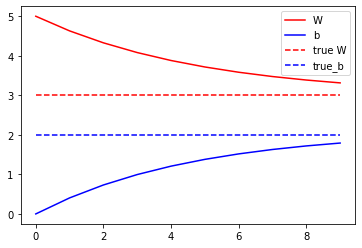

In [9]:
model = Model()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(model(inputs), outputs)

    train(model, inputs, outputs, learning_rate=0.1)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' % (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()